# Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import getpass

 # Kaggle API Setup and Data Download

In [23]:
DATA_DIR = 'data/raw'
COMPETITION_NAME = 'walmart-recruiting-store-sales-forecasting'

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

try:
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()
    print("Kaggle API authenticated successfully.")
except (ImportError, OSError):
    print("Kaggle API not found or configured. Attempting Colab setup...")
    try:
        from google.colab import files
        if not os.path.exists('/content/kaggle.json'):
            print("Please upload your kaggle.json file.")
            uploaded = files.upload()
            for fn in uploaded.keys():
                print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
        if not os.path.exists('~/.kaggle'):
            !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        print("Kaggle API authenticated successfully in Colab.")

    except Exception as e:
        print(f"Could not configure Kaggle API. Please ensure you are in a Colab environment or have your API key set up locally.")
        print(f"Error: {e}")
        api = None
if api:
    required_files = ['train.csv.zip', 'test.csv.zip', 'features.csv.zip', 'stores.csv']
    files_missing = False
    for f in required_files:
        if not os.path.exists(os.path.join(DATA_DIR, f)):
            files_missing = True
            break

    if files_missing:
        print(f"Downloading data for competition '{COMPETITION_NAME}'...")
        api.competition_download_files(COMPETITION_NAME, path=DATA_DIR, quiet=False)
        print("Data downloaded.")
    else:
        print("Data files already exist. Skipping download.")
else:
    print("Cannot download data. Please check your Kaggle API setup.")




Kaggle API authenticated successfully.
Data files already exist. Skipping download.


#3. Unzip Data Files

In [24]:
master_zip_path = os.path.join(DATA_DIR, f'{COMPETITION_NAME}.zip')
if os.path.exists(master_zip_path):
    print(f"Found master zip file: {master_zip_path}. Extracting...")
    with zipfile.ZipFile(master_zip_path, 'r') as z:
        z.extractall(DATA_DIR)
    print("Master zip file extracted.")

Found master zip file: data/raw/walmart-recruiting-store-sales-forecasting.zip. Extracting...
Master zip file extracted.


# 4.DATA LOADING AND MERGING

In [25]:
print("\nLoading and merging data...")
try:
    with zipfile.ZipFile(os.path.join(DATA_DIR, 'train.csv.zip'), 'r') as z:
        train_df = pd.read_csv(z.open('train.csv'))
    with zipfile.ZipFile(os.path.join(DATA_DIR, 'test.csv.zip'), 'r') as z:
        test_df = pd.read_csv(z.open('test.csv'))
    with zipfile.ZipFile(os.path.join(DATA_DIR, 'features.csv.zip'), 'r') as z:
        features_df = pd.read_csv(z.open('features.csv'))
    stores_df = pd.read_csv(os.path.join(DATA_DIR, 'stores.csv'))

    train_merged_df = train_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
    train_merged_df = train_merged_df.merge(stores_df, on='Store', how='left')

    test_merged_df = test_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
    test_merged_df = test_merged_df.merge(stores_df, on='Store', how='left')
    print("Data loaded and merged successfully.")
except FileNotFoundError:
    print("\nERROR: Data files not found. Please ensure Kaggle download/unzipping was successful.")
    exit()


Loading and merging data...
Data loaded and merged successfully.


# 5. EXPLORATORY DATA ANALYSIS (EDA)

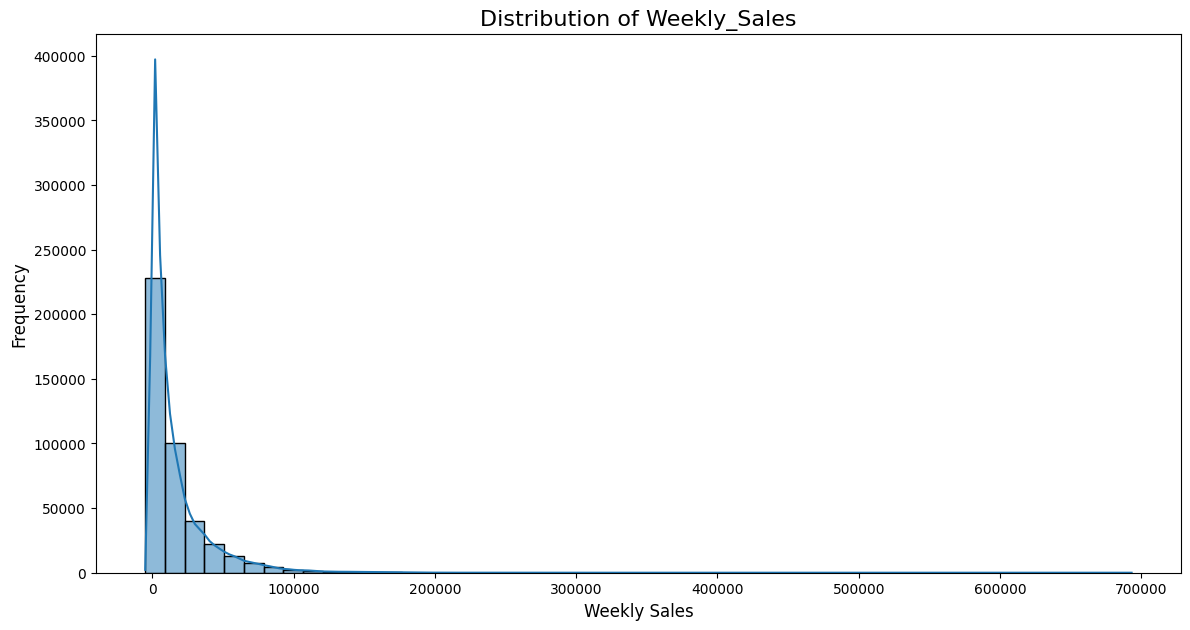


ANALYSIS OF WEEKLY_SALES DISTRIBUTION:
1.  Massive Skew: Most sales are clustered on the low end, with a long tail to the right. This means extremely high sales weeks are rare but exist.
2.  Non-Normal Data: This distribution is not a "bell curve".
3.  ACTION: For models like Neural Networks or ARIMA, applying a log transform (np.log1p) to this feature can help stabilize variance and improve performance. For tree-based models like LightGBM, this is less critical.



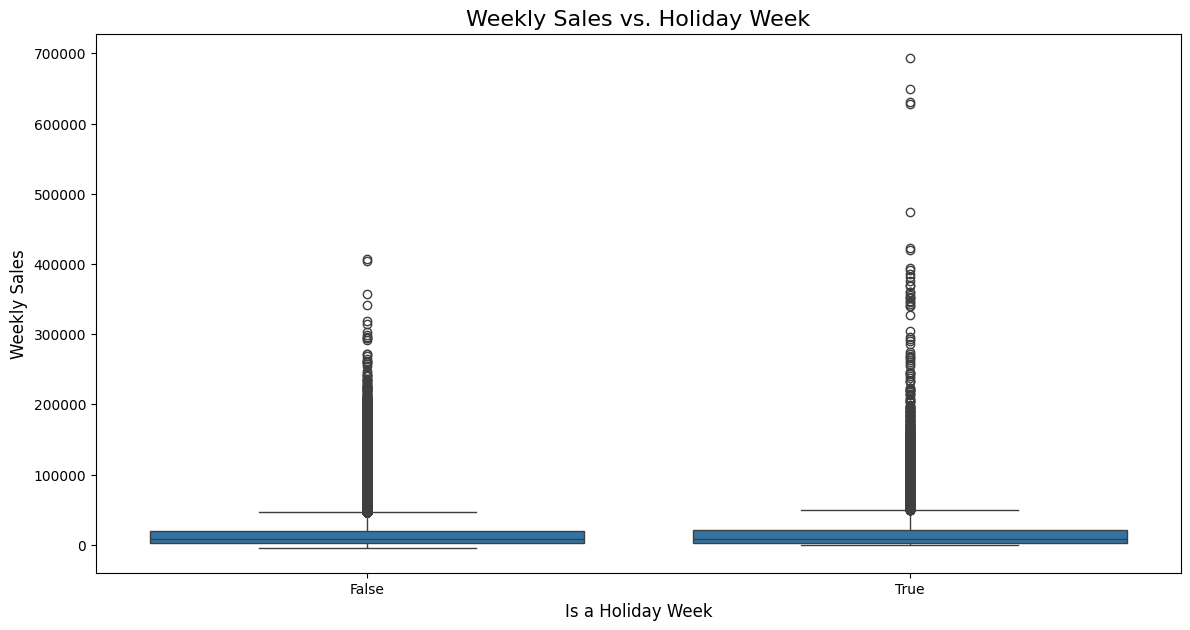


ANALYSIS OF HOLIDAY SALES:
1.  Higher Variance: The box for holiday weeks (True) is taller, indicating sales are more spread out and less predictable during these times.
2.  Many Outliers: Both categories have many high-sales outliers, but holiday weeks reach much higher values.
3.  ACTION: The simple 'IsHoliday' feature is not enough. We must create specific features for each major holiday, as they clearly have different effects.



In [26]:
#  Distribution of Weekly_Sales ---
plt.figure(figsize=(14, 7))
sns.histplot(train_merged_df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution of Weekly_Sales', fontsize=16)
plt.xlabel('Weekly Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

print("""
ANALYSIS OF WEEKLY_SALES DISTRIBUTION:
1.  Massive Skew: Most sales are clustered on the low end, with a long tail to the right. This means extremely high sales weeks are rare but exist.
2.  Non-Normal Data: This distribution is not a "bell curve".
3.  ACTION: For models like Neural Networks or ARIMA, applying a log transform (np.log1p) to this feature can help stabilize variance and improve performance. For tree-based models like LightGBM, this is less critical.
""")

#  Weekly Sales vs. Holiday Week ---
plt.figure(figsize=(14, 7))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=train_merged_df)
plt.title('Weekly Sales vs. Holiday Week', fontsize=16)
plt.xlabel('Is a Holiday Week', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.show()

print("""
ANALYSIS OF HOLIDAY SALES:
1.  Higher Variance: The box for holiday weeks (True) is taller, indicating sales are more spread out and less predictable during these times.
2.  Many Outliers: Both categories have many high-sales outliers, but holiday weeks reach much higher values.
3.  ACTION: The simple 'IsHoliday' feature is not enough. We must create specific features for each major holiday, as they clearly have different effects.
""")


# 6. ADVANCED FEATURE ENGINEERING & PREPROCESSING

In [27]:
def advanced_feature_engineering(df):
    """
    Performs our complete, optimized preprocessing and feature engineering pipeline.
    """
    df_copy = df.copy()

    # Convert 'Date' and handle potential negative sales by clipping at 0
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    if 'Weekly_Sales' in df_copy.columns:
        df_copy['Weekly_Sales'] = df_copy['Weekly_Sales'].clip(lower=0)

    # --- Feature: Specific Holidays
    # The 'Date' column is the Friday of that week. Thanksgiving is always a Thursday.
    # Therefore, the week of Thanksgiving in this dataset IS the week of Black Friday.
    thanksgiving_dates = pd.to_datetime(["2010-11-26", "2011-11-25"]) # Test data doesn't include 2012 Thanksgiving
    super_bowl_dates = pd.to_datetime(["2010-02-12", "2011-02-11", "2012-02-10"])
    labor_day_dates = pd.to_datetime(["2010-09-10", "2011-09-09", "2012-09-07"])
    christmas_dates = pd.to_datetime(["2010-12-31", "2011-12-30"])

    df_copy['IsBlackFridayWeek'] = df_copy.Date.isin(thanksgiving_dates).astype(int)
    df_copy['IsSuperBowlWeek'] = df_copy.Date.isin(super_bowl_dates).astype(int)
    df_copy['IsLaborDayWeek'] = df_copy.Date.isin(labor_day_dates).astype(int)
    df_copy['IsChristmasWeek'] = df_copy.Date.isin(christmas_dates).astype(int)

    # --- Feature: Basic Time-Based ---
    df_copy['Year'] = df_copy['Date'].dt.year
    df_copy['Month'] = df_copy['Date'].dt.month
    df_copy['WeekOfYear'] = df_copy['Date'].dt.isocalendar().week.astype(int)
    df_copy['DayOfWeek'] = df_copy['Date'].dt.dayofweek

    # --- Feature: Lag and Rolling (Time-Series Specific) ---
    df_copy.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)
    if 'Weekly_Sales' in df_copy.columns:
        df_copy['Sales_Lag_1'] = df_copy.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
        df_copy['Sales_Lag_52'] = df_copy.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
        df_copy['Sales_Roll_Mean_4'] = df_copy.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())

    # --- Handling Missing Values ---
    # Fill MarkDown with 0, as NaN means no promotion
    df_copy[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = df_copy[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']].fillna(0)

    # Fill any other NaNs (from lags, rolls, or original data)
    df_copy.fillna(method='ffill', inplace=True)
    df_copy.fillna(method='bfill', inplace=True)
    df_copy.fillna(0, inplace=True) # Fill any absolute remaining with 0

    # --- Encoding and Final Cleanup ---
    df_copy = pd.get_dummies(df_copy, columns=['Type'], prefix='Type')

    return df_copy

# Apply the function
train_processed = advanced_feature_engineering(train_merged_df)
test_processed = advanced_feature_engineering(test_merged_df.assign(Weekly_Sales=0)) # Add dummy column for processing

print("Advanced preprocessing complete.")

/tmp/ipython-input-27-3666432625.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='ffill', inplace=True)
/tmp/ipython-input-27-3666432625.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='bfill', inplace=True)


Advanced preprocessing complete.


/tmp/ipython-input-27-3666432625.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='ffill', inplace=True)
/tmp/ipython-input-27-3666432625.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='bfill', inplace=True)


# SAVING PROCESSED DATA

In [28]:
PROCESSED_DIR = 'data/processed'
if not os.path.exists(PROCESSED_DIR):
    os.makedirs(PROCESSED_DIR)

train_processed.to_csv(os.path.join(PROCESSED_DIR, 'train_processed_final.csv'), index=False)
test_processed.drop('Weekly_Sales', axis=1).to_csv(os.path.join(PROCESSED_DIR, 'test_processed_final.csv'), index=False)

print(f"Final processed data saved to '{PROCESSED_DIR}' directory.")
print("\nFinal processed data sample with new features:")
print(train_processed[['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsBlackFridayWeek', 'Sales_Lag_1', 'Sales_Roll_Mean_4']].head())


Final processed data saved to 'data/processed' directory.

Final processed data sample with new features:
        Date  Store  Dept  Weekly_Sales  IsBlackFridayWeek  Sales_Lag_1  Sales_Roll_Mean_4
0 2010-02-05      1     1      24924.50                  0     24924.50           32990.77
1 2010-02-12      1     1      46039.49                  0     24924.50           32990.77
2 2010-02-19      1     1      41595.55                  0     46039.49           32990.77
3 2010-02-26      1     1      19403.54                  0     41595.55           32990.77
4 2010-03-05      1     1      21827.90                  0     19403.54           32990.77
